In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
# import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp
kn.set_mpl_style()

In [8]:
df = kn.data.load_hyades_dataset()
df = df.loc[df['Member_r19']!='other'].copy()

In [9]:
def xyz_icrs_to_galactic(xyz):
    c = coord.ICRS(*xyz, representation_type="cartesian")
    return c.transform_to(coord.Galactic).cartesian.xyz.value
b_c = np.array([17.16461006, 41.27147655, 13.70518315])
b_c_gal = xyz_icrs_to_galactic(b_c)

In [10]:
r_c = np.linalg.norm(df.g.icrs.cartesian.xyz.value.T - b_c[None:], axis=1)
df['r_c'] = r_c
r_cut = 10

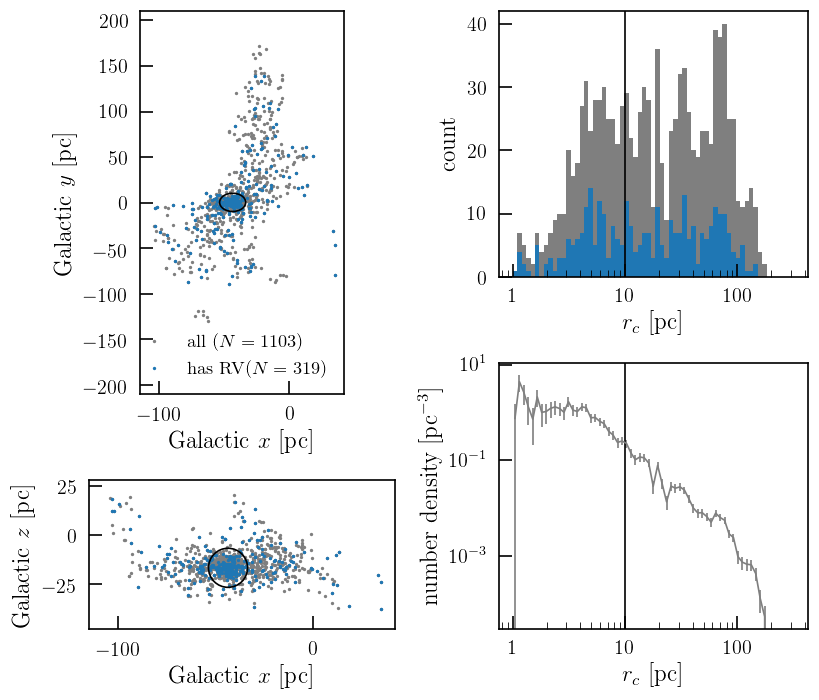

In [17]:
fig = plt.figure(figsize=(7,6))
gs = fig.add_gridspec(6, 2)
ax_xy = fig.add_subplot(gs[:4, 0], aspect=0.7)
ax_xz = fig.add_subplot(gs[-2:, 0], sharex=ax_xy,aspect='equal')

df_rv = df.groupby(df['radial_velocity'].notna()).get_group(True)

ax_numhist = fig.add_subplot(gs[:3, 1])
ax_numdens = fig.add_subplot(gs[3:, 1], sharex=ax_numhist)


ax_xz.set_xlim(-115, 42)
ax_xz.set_ylim((-48, 28))

ax_xy.scatter(df["gx"], df["gy"], s=1, c='tab:gray', label='all ($N={}$)'.format(len(df)))
ax_xz.scatter(df["gx"], df["gz"], s=1, c='tab:gray')
ax_xy.scatter(df_rv["gx"], df_rv["gy"], s=1, c='C0', label='has RV($N={}$)'.format(len(df_rv)))
ax_xz.scatter(df_rv["gx"], df_rv["gz"], s=1, c='C0')
ax_xy.legend(loc='lower right', fontsize=11, frameon=False)
ax_xy.set_ylim(-210,210)

ax_xy.set_xlabel('Galactic $x$ [pc]')
ax_xy.set_ylabel('Galactic $y$ [pc]')

ax_xz.set_xlabel('Galactic $x$ [pc]')
ax_xz.set_ylabel('Galactic $z$ [pc]')

nr, bin_edges, patches = ax_numhist.hist(
    df["r_c"], np.logspace(0, 2.5, 64), color='tab:gray')
ax_numhist.hist(
    df_rv["r_c"], np.logspace(0, 2.5, 64), color='C0');

ax_numhist.set_xscale("log")
ax_numhist.set_xlabel("$r_c$ [pc]")
ax_numhist.set_ylabel("count")
ax_numhist.axvline(
    r_cut, c="k",
)

bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
numdens = nr / (bin_centers ** 2 * 4 * np.pi) / (bin_edges[1] - bin_edges[0])
numdens_err = (
    np.sqrt(nr) / (bin_centers ** 2 * 4 * np.pi) / (bin_edges[1] - bin_edges[0])
)
ax_numdens.errorbar(bin_centers, numdens, numdens_err, c='tab:gray')
ax_numdens.set_xscale("log")
ax_numdens.set_yscale("log")
ax_numdens.set_xlabel("$r_c$ [pc]")
ax_numdens.set_ylabel("number density [$\mathrm{pc}^{-3}$]")
ax_numdens.axvline(
    r_cut, c="k",
)
from matplotlib.ticker import ScalarFormatter
ax_numhist.xaxis.set_major_formatter(ScalarFormatter())

# ax_numhist.set_xticks([2,3,4,5],minor=True)
ax_numhist.tick_params(axis='x',which='minor',length=4,width=0.5)
ax_numdens.tick_params(axis='both',which='minor',length=4,width=0.5)

from matplotlib.patches import Circle
for circ_radius in [10]:
    circle_xy = Circle(
        [b_c_gal[0], b_c_gal[1]], circ_radius, facecolor="None", edgecolor="k",
        label=r'$r_c=10~\mathrm{pc}$', 
    )
    circle_xz = Circle(
        [b_c_gal[0], b_c_gal[2]], circ_radius, facecolor="None", edgecolor="k",
        label=r'$r_c=10~\mathrm{pc}$', 
    )
    ax_xy.add_patch(circle_xy)
    ax_xz.add_patch(circle_xz)

# ax_xy.legend()
fig.tight_layout()

fig.savefig('../report/plots/1-summarize-and-plot-sample/sampledist.pdf')

In [18]:
print((df['r_c']<r_cut).sum())

400
